In [2]:
import numpy as np
import torch
from torchvision.datasets import STL10
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [26]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((6, 6)),
    transforms.ToTensor()
])

train_dataset = STL10(root="./data", split='train', transform=transform, download=True)
test_dataset = STL10(root="./data", split='test', transform=transform, download=True)
dir(train_dataset)
dir(test_dataset)

selected_classes = [0, 1, 2, 3, 4]

Files already downloaded and verified
Files already downloaded and verified


In [12]:
train_indices = [i for i, label in enumerate(train_dataset.labels) if label in selected_classes]
train_dataset = Subset(train_dataset, train_indices)


test_indices = [i for i, label in enumerate(test_dataset.labels) if label in selected_classes]
test_dataset = Subset(test_dataset, test_indices)


In [13]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


In [14]:
train_data, train_labels = next(iter(train_loader))
test_data, test_labels = next(iter(test_loader))

print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Train data shape: torch.Size([2500, 1, 6, 6]), Train labels shape: torch.Size([2500])
Test data shape: torch.Size([4000, 1, 6, 6]), Test labels shape: torch.Size([4000])


In [15]:
X_train = train_data.view(train_data.shape[0], -1).numpy()
y_train = train_labels.numpy()

X_test = test_data.view(test_data.shape[0], -1).numpy()
y_test = test_labels.numpy()


X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Processed X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Processed X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Processed X_train shape: (2500, 36), y_train shape: (2500,)
Processed X_test shape: (4000, 36), y_test shape: (4000,)


In [27]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=0.1,
        penalty='l2'
    )
clf.fit(X_train, y_train)


train_accuracy = clf.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


Training Accuracy: 34.48%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [17]:
y_pred = clf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy :.2%}%")

print("Classification Report:")

print(
      classification_report(
                           y_test,
                           y_pred,
                           target_names=[f"Class {i}" for i in selected_classes]
                           )
     )


Test Accuracy: 34.75%%
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.32      0.70      0.44       800
     Class 1       0.51      0.02      0.05       800
     Class 2       0.38      0.82      0.52       800
     Class 3       0.35      0.06      0.10       800
     Class 4       0.32      0.14      0.19       800

    accuracy                           0.35      4000
   macro avg       0.38      0.35      0.26      4000
weighted avg       0.38      0.35      0.26      4000



In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)


knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"KNN Test Accuracy: {knn_accuracy:.2%}%")

KNN Test Accuracy: 42.08%%


In [29]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print(f"Original train size: {X_train.shape}, After ROS: {X_train_ros.shape}")

Original train size: (2500, 36), After ROS: (2500, 36)


In [20]:
clf.fit(X_train_ros, y_train_ros)

y_pred_ros = clf.predict(X_test)
ros_accuracy = accuracy_score(y_test, y_pred_ros)
print(f"Logistic Regression with ROS Test Accuracy: {ros_accuracy:.2%}%")

Logistic Regression with ROS Test Accuracy: 34.75%%


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


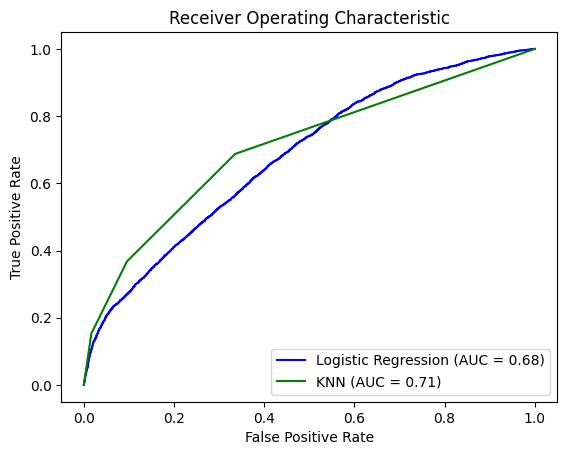

In [31]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier


y_test_binarized = label_binarize(y_test, classes=selected_classes)


y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})", color='blue')


if hasattr(knn, "predict_proba"):
    y_score_knn = knn.predict_proba(X_test)
    fpr_knn, tpr_knn, _ = roc_curve(y_test_binarized.ravel(), y_score_knn.ravel())
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {roc_auc_knn:.2f})", color='green')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()


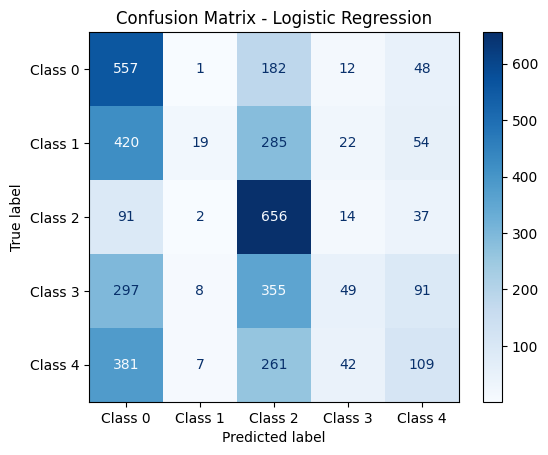

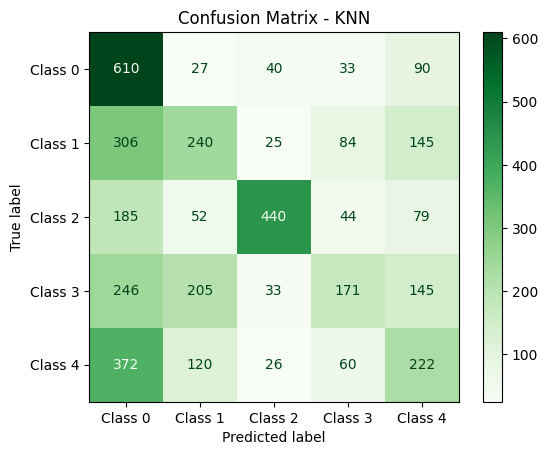

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"Class {i}" for i in selected_classes])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=[f"Class {i}" for i in selected_classes])
disp_knn.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix - KNN")
plt.show()


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

precision_knn = precision_score(y_test, y_pred_knn, average='weighted')
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
print(f"KNN Precision: {precision_knn:.2f}, Recall: {recall_knn:.2f}, F1-Score: {f1_knn:.2f}")


Precision: 0.38, Recall: 0.35, F1-Score: 0.26
KNN Precision: 0.45, Recall: 0.42, F1-Score: 0.41


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

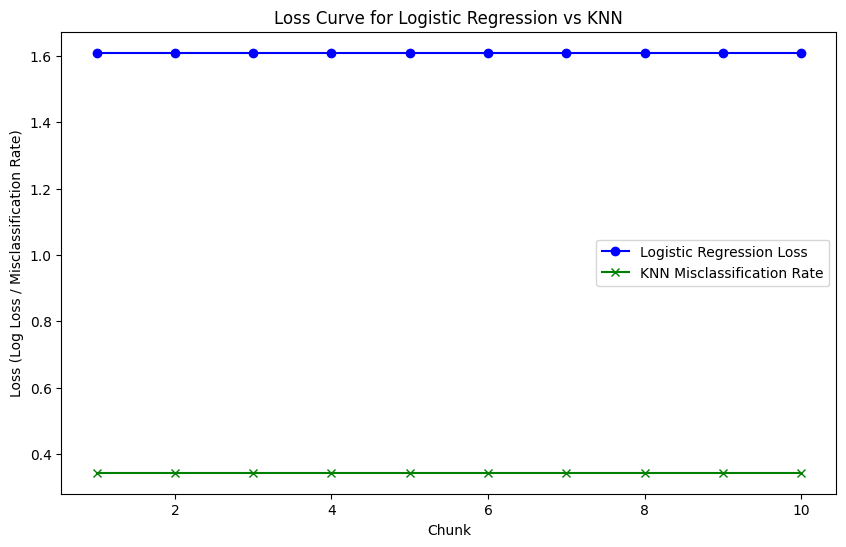

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


def calculate_misclassification_rate(model, X, y):
    y_pred = model.predict(X)
    misclassification_rate = 1 - accuracy_score(y, y_pred)
    return misclassification_rate


log_losses = []
knn_losses = []

chunk_size = len(X_train)

for i in range(1, 11):

    clf = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        C=0.1,
        penalty='l2',
        max_iter=500
    )
    clf.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    y_pred_train = clf.predict_proba(X_train)
    log_losses.append(log_loss(y_train, y_pred_train))


    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[:i * chunk_size], y_train[:i * chunk_size])
    knn_loss = calculate_misclassification_rate(knn, X_train[:i * chunk_size], y_train[:i * chunk_size])
    knn_losses.append(knn_loss)


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(log_losses) + 1), log_losses, marker='o', label='Logistic Regression Loss', color='blue')
plt.plot(range(1, len(knn_losses) + 1), knn_losses, marker='x', label='KNN Misclassification Rate', color='green')
plt.xlabel("Chunk")
plt.ylabel("Loss (Log Loss / Misclassification Rate)")
plt.title("Loss Curve for Logistic Regression vs KNN")
plt.legend()
plt.show()
